# Graph Overview

MLRun graph enables you to perform data processing in real-time and at scale. The graph is composed of individual steps, where each step receives an event and outputs an event that is passed to the next step.

Capabilities:

- Easily build and manage complex graphs
- Real-time serverless engine for optimized utilization (auto scale up/down)
- Support advanced applications including streaming, machine learning, deep-learning, NLP
- Debug in the IDE/Notebook, deploy to production using a single command

Different steps can run on the same local function, or run on a remote function. This allows calling existing functions from the graph and reuse them from other graphs as well as scale up and down different components individually.

## Basic Concepts

MLRun Graphs enable building and running DAGs (directed acyclic graph), the first graph element accepts
an `Event` object, transform/process the event and pass the result to the next steps
in the graph. The final result can be written out to some destination (file, DB, stream, ..)
or return back to the caller (one of the graph steps can be marked with `.respond()`).

The graph is composed of the following:

- **Step** &mdash; A Step runs a function or class handler or a REST API call. MLRun comes with a list of [pre-built steps](./available-steps.md)
  which include data manipluation, readers, writers and model serving. Users can also write their own steps using standard Python
  functions or custom functions/classes, or can be a external REST API (the special `$remote` class).
- **Router** &mdash; A special type of step is a router with routing logic and multiple child routes/models.
  The basic routing logic is to route to the child routes based on the Event.path,
  more advanced or custom routing can be used, for example the ensemble router sends the event to all
  child routes in parallel, aggregate the result and respond.
- **Queue** &mdash; A queue or stream which accept data from one or more source steps and publish
  to one or more output steps, queues are best used to connect independent functions/containers.
  queue can run in-memory or be implemented using a stream which allow it to span processes/containers.

The Graph server have two modes of operation (topologies):

- **Router topology** (default)- a minimal configuration with a single router and child tasks/routes,
  this can be used for simple model serving or single hop configurations.
- **Flow topology** - a full graph/DAG, the flow topology is implemented using two engines, `async` (the default)
  is based on [Storey](https://github.com/mlrun/storey) and asynchronous event loop, and `sync` which support a simple
  sequence of steps.

## Basic Example

### Steps

The following code defines basic steps which we'll use to build a graph. These steps are

- **`inc`** which increment the value by 1.
- **`mul`** which multiplies the value by 2.
- **`WithState`** class which increments an internal counter, prints an output and adds to the input value the current counter.

In [1]:
# mlrun: start-code

def inc(x):
    return x + 1

def mul(x):
    return x * 2

class WithState:
    def __init__(self, name, context, init_val=0):
        self.name = name
        self.context = context
        self.counter = init_val

    def do(self, x):
        self.counter += 1
        print(f"Echo: {self.name}, x: {x}, counter: {self.counter}")
        return x + self.counter
    
# mlrun: end-code

### Create a function

The following takes the code above and creates an MLRun function called `serving-graph`

In [2]:
import mlrun
fn = mlrun.code_to_function("simple-graph", kind="serving", image="mlrun/mlrun")
graph = fn.set_topology("flow")

### Build the graph

Use `graph.to()` to chain steps, use `.respond()` to mark that the output of that step will be returned to the caller
(as http response), by default the graph is async with no response.

In [3]:
graph.to(name="+1", handler='inc')\
     .to(name="*2", handler='mul')\
     .to(name="(X+counter)", class_name='WithState').respond()

### Visualize the graph

Using the `plot` method, you can visualize the graph

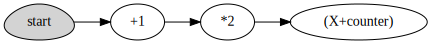

In [4]:
graph.plot(rankdir='LR')

### Test the Function

Create a mock server and test the graph locally. Because this graph accepts a numeric value as the input, we provide that value
in the `body` parameter.

In [5]:
server = fn.to_mock_server()
server.test(body=5)

Echo: (X+counter), x: 12, counter: 1


13

Run the function again, this time, the counter should be 2 and the output should be 14

In [6]:
server.test(body=5)

Echo: (X+counter), x: 12, counter: 2


14

### Deploy the Function

Using the `deploy` method, we can now deploy the function

In [7]:
fn.deploy(project='basic-graph-demo')

> 2021-11-08 07:30:21,571 [info] Starting remote function deploy
2021-11-08 07:30:21  (info) Deploying function
2021-11-08 07:30:21  (info) Building
2021-11-08 07:30:21  (info) Staging files and preparing base images
2021-11-08 07:30:21  (info) Building processor image
2021-11-08 07:30:26  (info) Build complete
2021-11-08 07:30:31  (info) Function deploy complete
> 2021-11-08 07:30:31,785 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-basic-graph-demo-simple-graph.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['basic-graph-demo-simple-graph-basic-graph-demo.default-tenant.app.aganefaibuzg.iguazio-cd2.com/']}


'http://basic-graph-demo-simple-graph-basic-graph-demo.default-tenant.app.aganefaibuzg.iguazio-cd2.com/'

### Test the Deployed Function

Using the `invoke` method we can now call the function.

In [8]:
fn.invoke('', body=5)

> 2021-11-08 07:30:43,241 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-basic-graph-demo-simple-graph.default-tenant.svc.cluster.local:8080/'}


13

In [9]:
fn.invoke('', body=5)

> 2021-11-08 07:30:48,359 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-basic-graph-demo-simple-graph.default-tenant.svc.cluster.local:8080/'}


14

## Graph Usages

### Data Preparation

An ETL process requires transformation of data. MLRun graph supports defining those transformations with a user-friendly Python
interface. These transformations are invoked at real-time.

For an example, see the [NLP data preparation distributed pipeline example](./nlp-distributed-graph.ipynb)


### Model Serving

Serverless functions can serve one or more models. It is common that the input to the model requires data manipulation. Using graphs
one can create a data perparation pipeline prior to calling the model itself. For more information refer to the [serving graph overview page](../model-serving/serving-graph.ipynb) as well as a [serving graph example](../model-serving/serving-graph-example.ipynb)


### Feature store

The MLRun feature store defines a group of features can be ingested together and stored in logical group called feature set. The
feature set includes a set of transformations in order to define those features. For more information and examples refer to the
[feature set page](../../feature-store/feature-sets.md)

## References

- MLRun graph includes a list of out-of-the-box steps. Refer to the [list of available steps](./available-steps) for more information.
- For more information about writing your own custom steps, similar to the example above, refer to the [writing custom steps page](./writing-custom-steps.ipynb).
- For advanced topics such as exception handling and remote execution, see the [advanced graph usage](./advanced-graph-usage.ipynb).

```{toctree}
:maxdepth: 1
:hidden: true

available-steps
writing-custom-steps
advanced-graph-usage
nlp-distributed-graph

```